# Analyzing Trajectory Data and Bistatic Angles

In this notebook, we will analyze the trajectory data of two carriers, SETHI and BUSARD, and compute several key parameters, including the distance to a target, bistatic angles (both 'ground' and 'radar'), and azimuths of observation of the target. We will also visualize these parameters over time. The dataset we use is in CSV format and contains positional information of the two carriers.

<img src="bistatic_angles.png" width="800" style="background-color:white;">

## 1. Importing Required Libraries

Before we begin analyzing the data, we first need to import the necessary libraries.

- `sargeom`: A Python library for working with geospatial coordinates and geometric transformations.
- `matplotlib`: Used for plotting the results.
- `pandas`: For data manipulation and reading CSV files.
- `numpy`: For numerical computations.

In [50]:
from sargeom.coordinates import Cartographic, Cartesian3
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## 2. Loading and Preparing the Data

Next, we load the trajectory data for SETHI and BUSARD. These datasets contain information about the longitude, latitude, and heading of each object.

- The `LON_WGS84_DEG`, `LAT_WGS84_DEG`, and `HEADING_DEG` columns represent the longitude, latitude, and heading (in degrees), respectively.

In [51]:
# Loading trajectory data for SETHI
sethi_trajectory_data = pd.read_csv('data/20230627_SETHI.traj.csv', delimiter=';', comment='#')

# Loading trajectory data for BUSARD
busard_trajectory_data = pd.read_csv('data/20230627_BUSARD.traj.csv', delimiter=';', comment='#')

## 3. Defining Cartographic Objects

For each dataset, we create Cartographic objects that will allow us to perform geospatial transformations. The Cartographic object takes the longitude, latitude, and heading in degrees.

In [52]:
# Create Cartographic objects for SETHI, BUSARD, and the target
sethi_cartographic = Cartographic(
    longitude=sethi_trajectory_data.LON_WGS84_DEG.tolist(),
    latitude=sethi_trajectory_data.LAT_WGS84_DEG.tolist(),
    height=sethi_trajectory_data.HEADING_DEG.tolist()
)

busard_cartographic = Cartographic(
    longitude=busard_trajectory_data.LON_WGS84_DEG.tolist(),
    latitude=busard_trajectory_data.LAT_WGS84_DEG.tolist(),
    height=busard_trajectory_data.HEADING_DEG.tolist()
)

target_cartographic = Cartographic(
    longitude=-0.420314, # degrees
    latitude=44.238512, # degrees
    height=120.0 # meters
)

## 4. Converting Coordinates to ECEF (Earth-Centered, Earth-Fixed)

The next step is to convert the Cartographic coordinates (longitude, latitude, and heading) into ECEF coordinates, which represent the positions in a 3D Cartesian coordinate system.

In [53]:
# Convert the Cartographic coordinates to ECEF (x, y, z) for each object and the target
sethi_ecef = sethi_cartographic.to_ecef()
busard_ecef = busard_cartographic.to_ecef()
target_ecef = target_cartographic.to_ecef()

## 5. Interpolating BUSARD Data to Match SETHI's Timestamps

Since the timestamps for SETHI and BUSARD might not perfectly align, we will interpolate the BUSARD data to match the timestamps of SETHI.

In [54]:
# Interpolate BUSARD's ECEF coordinates to match SETHI's timestamps
busard_ecef_interpolated = busard_ecef.interp(busard_trajectory_data.TIMESTAMP_S, sethi_trajectory_data.TIMESTAMP_S)

## 6. Computing Distances to the Target

We then compute the distances from SETHI and BUSARD to the target using the `sargeom.coordinates.Cartesian3.distance` method, which calculates the Euclidean distance between two points in 3D space.

In [55]:
# Compute distances to the target
sethi_dist = Cartesian3.distance(sethi_ecef, target_ecef)
busard_dist = Cartesian3.distance(busard_ecef_interpolated, target_ecef)

## 7. Converting Coordinates from ECEF to ENU (East-North-Up)

Next, we convert the ECEF coordinates to ENU coordinates relative to the target. This transformation helps us interpret the positions in a local, target-centered coordinate system.

In [56]:
# Convert from ECEF to ENU coordinates, centered on the target
sethi_enu = sethi_ecef.to_enu(target_cartographic)
busard_enu = busard_ecef_interpolated.to_enu(target_cartographic)

## 8. Calculating the Bistatic Angles

We now calculate two sets of bistatic angles:

1. **Bistatic angle 'ground'**: The angle between the projections of the sensor positions onto the ground plane (z = 0).
2. **Bistatic angle 'radar'**: The angle between the full 3D vectors.

In [57]:
# Calculate bistatic angles between SETHI and BUSARD, with respect to the ground plane
angles_bist_ground = Cartesian3.angle_btw(
    Cartesian3(sethi_enu.x, sethi_enu.y, np.zeros(sethi_enu.y.shape)),
    Cartesian3(busard_enu.x, busard_enu.y, np.zeros(busard_enu.y.shape))
)

# Calculate bistatic angles 'radar' in 3D
angles_bist_radar = Cartesian3.angle_btw(sethi_enu, busard_enu)

## 9. Computing Azimuths of Observation

Using the normalized ENU vectors for SETHI and BUSARD, we calculate the azimuths of the target from each sensor. This is done by transforming the vectors to AER (Azimuth-Elevation-Range) coordinates.

In [58]:
# Compute azimuths of observation of the target
az_bissection, _, _ = (sethi_enu.normalize() + busard_enu.normalize()).to_aer()

## 10. Plotting the Results

Finally, we visualize the results by plotting the distances, bistatic angles, and azimuths over time.

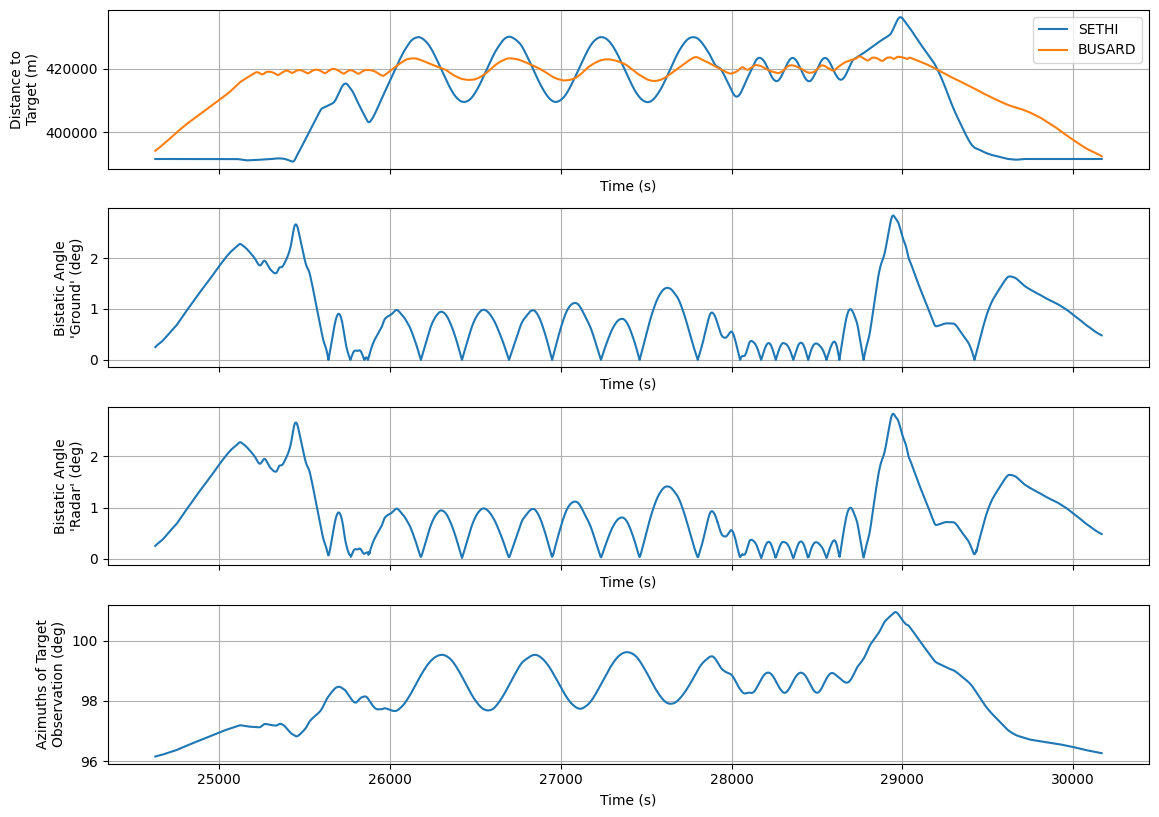

In [59]:
# Create a figure with multiple subplots for visualization
fig, axs = plt.subplots(4, 1, figsize=(11.69,8.27), sharex=True)

# Plot distance to target
axs[0].plot(sethi_trajectory_data.TIMESTAMP_S, sethi_dist, color='tab:blue', label='SETHI')
axs[0].plot(sethi_trajectory_data.TIMESTAMP_S, busard_dist, color='tab:orange', label='BUSARD')
axs[0].grid()
axs[0].legend()
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Distance to\nTarget (m)")

# Plot bistatic angles (ground)
axs[1].plot(sethi_trajectory_data.TIMESTAMP_S, np.unwrap(angles_bist_ground, period=360))
axs[1].grid()
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Bistatic Angle\n'Ground' (deg)")

# Plot bistatic angles (radar)
axs[2].plot(sethi_trajectory_data.TIMESTAMP_S, np.unwrap(angles_bist_radar, period=360))
axs[2].grid()
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Bistatic Angle\n'Radar' (deg)")

# Plot azimuths of target observation
axs[3].plot(sethi_trajectory_data.TIMESTAMP_S, az_bissection % 360)
axs[3].grid()
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Azimuths of Target\nObservation (deg)")

plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we demonstrated how to process trajectory data, calculate distances and angles, and visualize key parameters like bistatic angles and azimuths. This analysis is important for applications such as radar tracking and geospatial data analysis.